In [1]:
import torch
from torch import nn, optim
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
from transformers import CLIPModel, CLIPImageProcessor
from torchvision.ops import sigmoid_focal_loss
from tqdm import tqdm
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


In [2]:
processor = CLIPImageProcessor.from_pretrained("openai/clip-vit-base-patch32")
MEAN = processor.image_mean
STD  = processor.image_std
SIZE = processor.size["shortest_edge"] if isinstance(processor.size, dict) else processor.size

transform = transforms.Compose([
    transforms.Resize((SIZE, SIZE)),
    transforms.ToTensor(),
    transforms.Normalize(mean=MEAN, std=STD),
])

train_dir = "data_classification/augmented/train"
test_dir  = "data_classification/augmented/test"

train_dataset = datasets.ImageFolder(train_dir, transform=transform)
test_dataset  = datasets.ImageFolder(test_dir,  transform=transform)
train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True,  num_workers=4, pin_memory=True)
test_loader  = DataLoader(test_dataset,  batch_size=128, shuffle=False, num_workers=4, pin_memory=True)

clip = CLIPModel.from_pretrained("openai/clip-vit-base-patch32", weights_only=False).to(device)

for p in clip.parameters():
    p.requires_grad = False

# Feature dim after visual projection
feat_dim = clip.visual_projection.out_features  # CLIP's embedding size

# Binary head: 1 logit
head = nn.Linear(feat_dim, 1).to(device)
head.requires_grad_(True)

optimizer = optim.Adam(head.parameters(), lr=1e-3)

def focal_criterion(logits, targets, alpha=0.25, gamma=2.0):
    # logits: (N,1), targets: float (N,1) with 0/1
    return sigmoid_focal_loss(
        inputs=logits,           # raw logits
        targets=targets,         # 0/1 floats, same shape
        alpha=alpha,
        gamma=gamma,
        reduction="mean"
    )
    

In [3]:

def extract_image_features(imgs: torch.Tensor) -> torch.Tensor:
    """
    imgs: (N,3,H,W) already CLIP-normalized.
    Returns: (N, feat_dim) projected image embeddings.
    """
    with torch.no_grad():  # backbone frozen; saves memory
        vis_out = clip.vision_model(pixel_values=imgs)   # .pooler_output shape (N, hidden)
        pooled = vis_out.pooler_output
        feats = clip.visual_projection(pooled)           # (N, feat_dim)
    return feats

def train_one_epoch():
    head.train()
    total_loss = 0.0
    for imgs, labels in tqdm(train_loader, leave=False):
        imgs = imgs.to(device, non_blocking=True)
        labels = labels.float().unsqueeze(1).to(device, non_blocking=True)  # (N,1)

        feats = extract_image_features(imgs)   # (N, feat_dim)
        logits = head(feats)                   # (N,1)
        loss = focal_criterion(logits, labels, alpha=0.25, gamma=2.0)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_loss += loss.item() * imgs.size(0)
    return total_loss / len(train_loader.dataset)

@torch.no_grad()
def evaluate():
    head.eval()
    total = 0
    correct = 0
    total_loss = 0.0
    for imgs, labels in tqdm(test_loader, leave=False):
        imgs = imgs.to(device, non_blocking=True)
        labels_float = labels.float().unsqueeze(1).to(device, non_blocking=True)

        feats = extract_image_features(imgs)
        logits = head(feats)
        labels_float = labels.float().unsqueeze(1).to(device)
        total_loss += focal_criterion(logits, labels_float, alpha=0.25, gamma=2.0).item() * imgs.size(0)

        preds = (torch.sigmoid(logits).squeeze(1) > 0.5).long().cpu()
        correct += (preds == labels).sum().item()
        total += labels.size(0)
    return correct / total, total_loss / total


In [4]:

# --- Train ---
epochs = 10
for ep in range(epochs):
    tr_loss = train_one_epoch()
    acc, val_loss = evaluate()
    print(f"Epoch {ep+1}/{epochs} | train_loss {tr_loss:.4f} | val_loss {val_loss:.4f} | acc {acc:.3f}")


Epoch 1/10 | train_loss 0.0602 | val_loss 0.0551 | acc 0.724


Epoch 2/10 | train_loss 0.0520 | val_loss 0.0519 | acc 0.724


Epoch 3/10 | train_loss 0.0483 | val_loss 0.0487 | acc 0.724


Epoch 4/10 | train_loss 0.0459 | val_loss 0.0467 | acc 0.724


Epoch 5/10 | train_loss 0.0442 | val_loss 0.0448 | acc 0.724


Epoch 6/10 | train_loss 0.0428 | val_loss 0.0440 | acc 0.724


Epoch 7/10 | train_loss 0.0418 | val_loss 0.0428 | acc 0.724


Epoch 8/10 | train_loss 0.0408 | val_loss 0.0412 | acc 0.724


Epoch 9/10 | train_loss 0.0399 | val_loss 0.0403 | acc 0.728


Epoch 10/10 | train_loss 0.0392 | val_loss 0.0397 | acc 0.747


              precision    recall  f1-score   support

    Negative     0.7429    0.9936    0.8501       157
    Positive     0.8571    0.1000    0.1791        60

    accuracy                         0.7465       217
   macro avg     0.8000    0.5468    0.5146       217
weighted avg     0.7745    0.7465    0.6646       217

[[156   1]
 [ 54   6]]


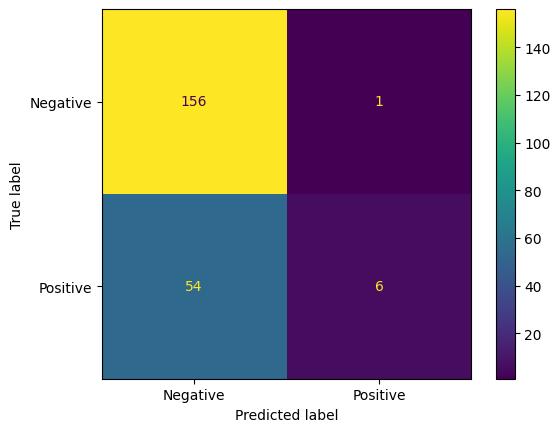

In [6]:

@torch.no_grad()
def collect_preds():
    head.eval()
    y_true, y_pred = [], []
    for imgs, labels in test_loader:
        imgs = imgs.to(device)
        feats = extract_image_features(imgs)
        logits = head(feats)
        preds = (torch.sigmoid(logits).squeeze(1) > 0.5).long().cpu().numpy()
        y_true.extend(labels.numpy())
        y_pred.extend(preds)
    return y_true, y_pred

y_true, y_pred = collect_preds()
print(classification_report(y_true, y_pred, target_names=train_dataset.classes, digits=4))
cm = confusion_matrix(y_true, y_pred)
print(cm)
ConfusionMatrixDisplay(cm, display_labels=train_dataset.classes).plot()
plt.show()